# Advanced Lane Lines Project
## 1st Step : Calibrating the camera:

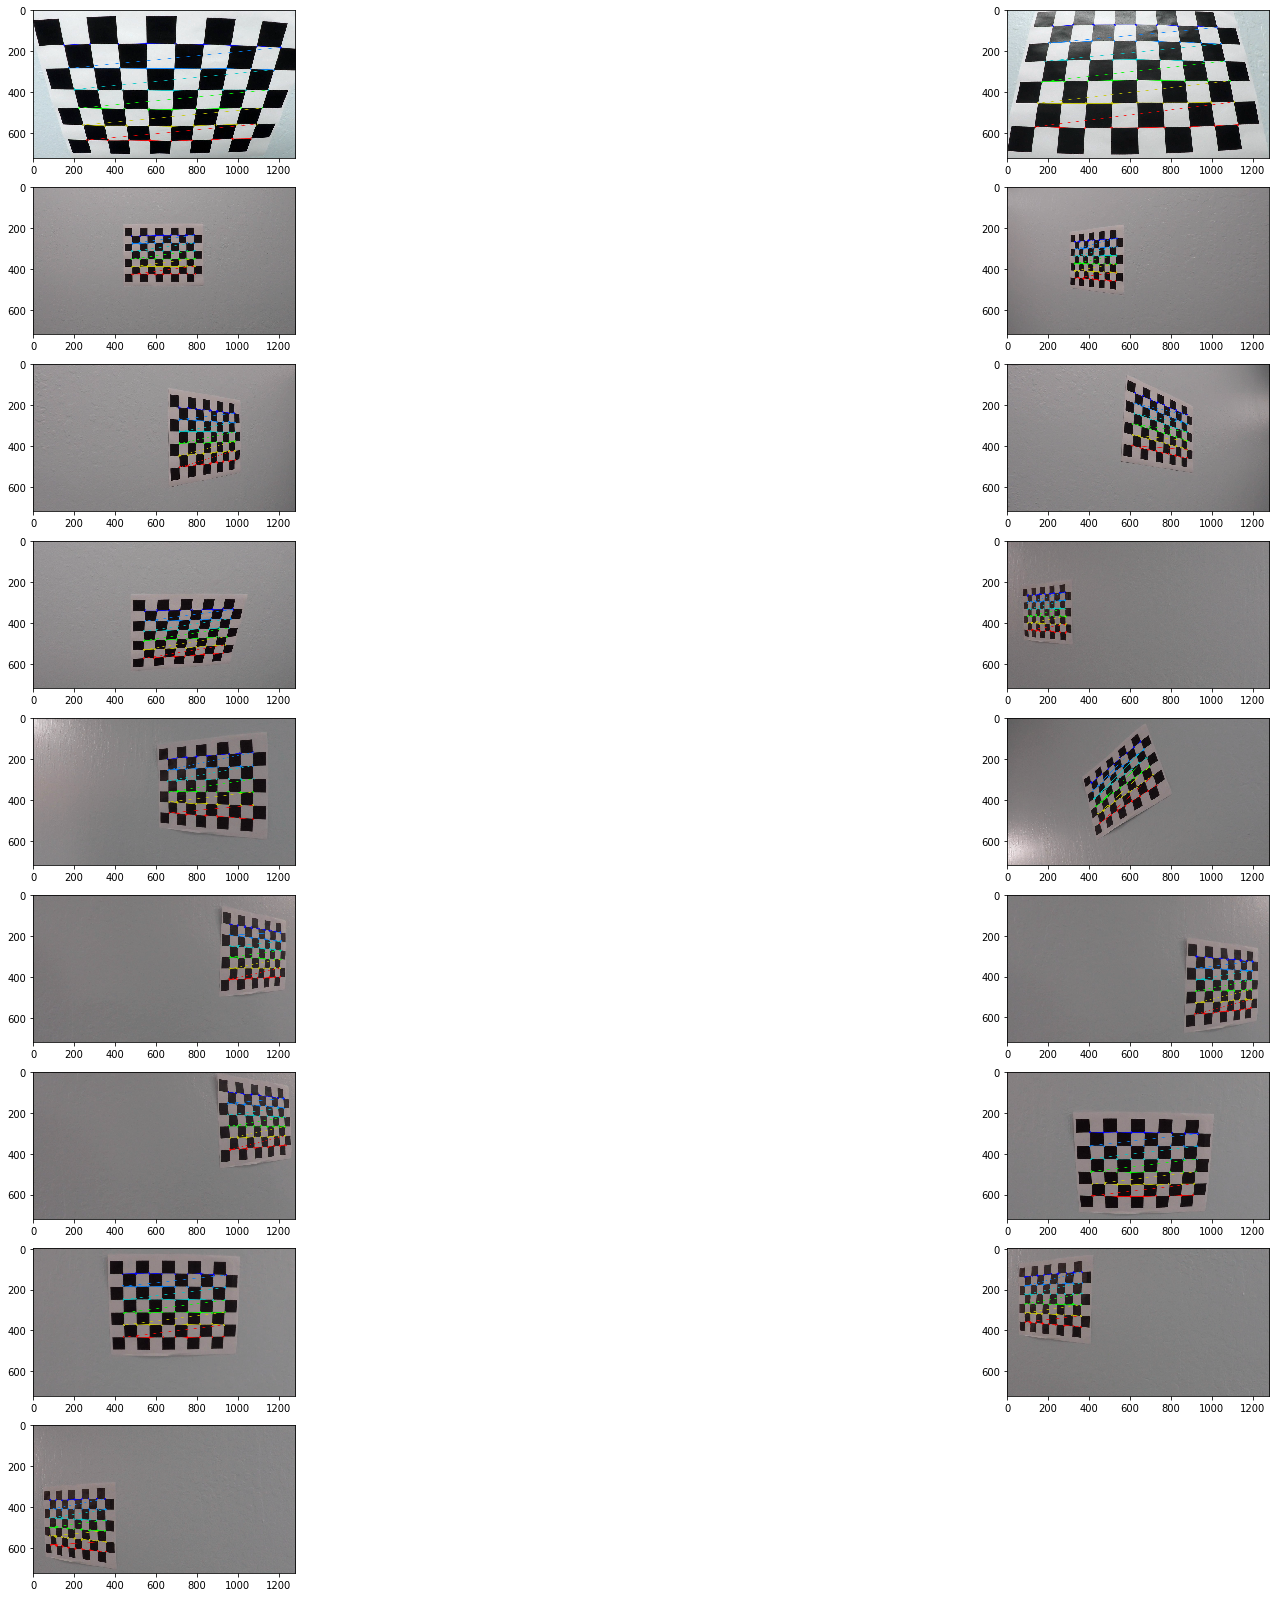

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# set the number of corners
nx = 9 #The number of inside corners in x
ny = 6 #The number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

fig = plt.figure(figsize=(32, 32))
j = 0
#Lopp over all the calibration images
for i in range(20):
    # Make a list of calibration images
    fname = './camera_cal/calibration' + str(i+1) + '.jpg'
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        j +=1
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.subplot(10,2,j)
        plt.imshow(img)
plt.show()


## 2nd Step : Undistort the image:

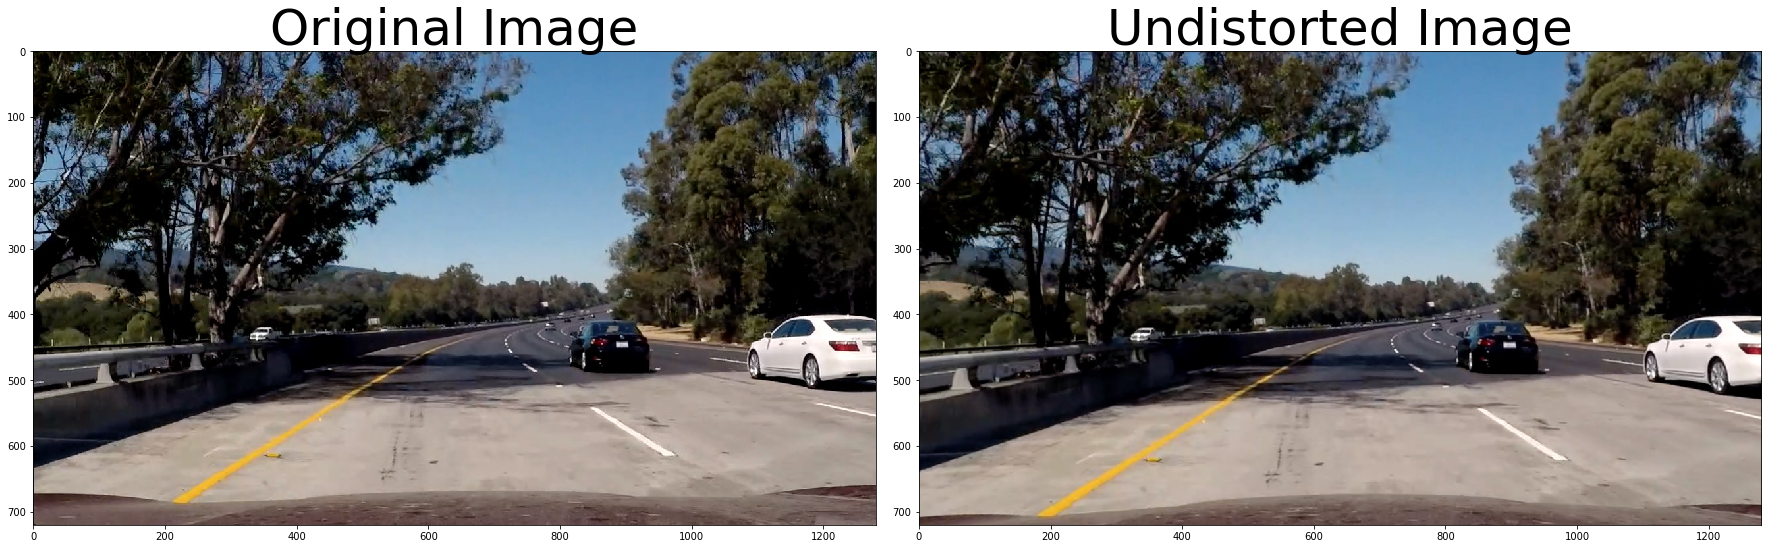

In [2]:
import cv2
# Read in an image
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# Print the original and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 3rd Step : Processing the image and merging the S channel, L channel and the gradient:

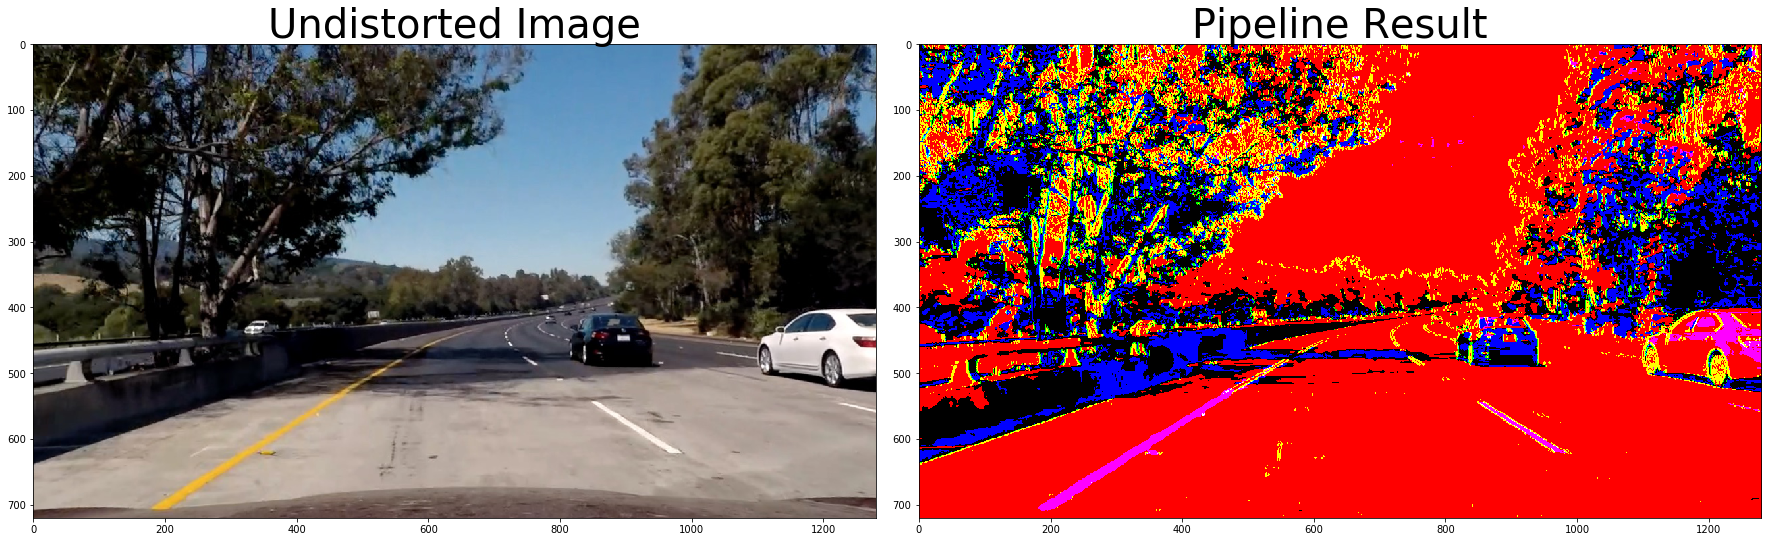

In [3]:
# Pipeline for merging the S channel, L channel and the gradient 
def pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( l_binary, sxbinary, s_binary))
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    return color_binary, binary
    
result, binary = pipeline(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 4th Step : Create a perspective transform and draw the corners:

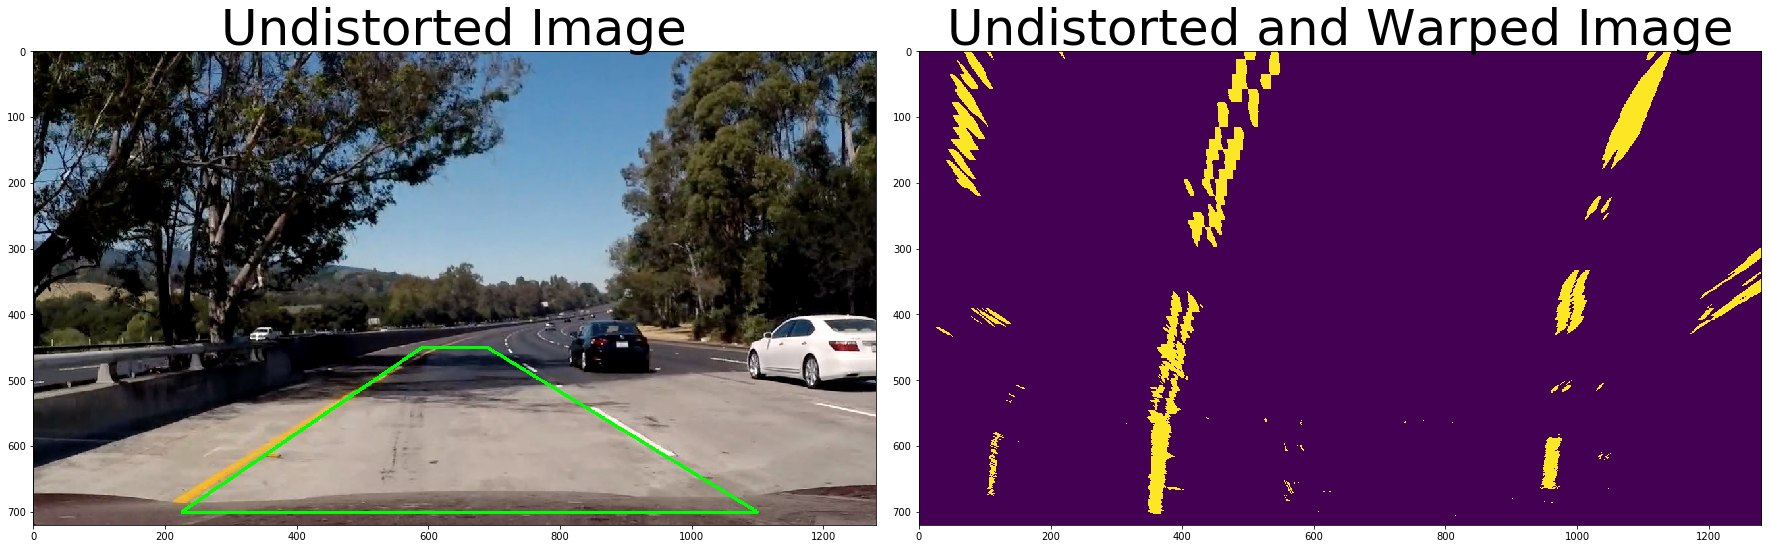

In [4]:
# Write a function that unwarps the image
def corners_unwarp(img, nx, ny, mtx, dist, src):        
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    new_top_left=np.array([src[0,0],0])
    new_top_right=np.array([src[3,0],0])
    offset=[150,0]
    dst = np.float32([src[0]+offset,new_top_left+offset,new_top_right-offset ,src[3]-offset])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (np.size(img,1),np.size(img,0)),flags=cv2.INTER_LINEAR)
    return warped

# Write a function that transforms a warped image to the initial shape
def corners_rewarp(img, nx, ny, mtx, dist, src):        
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    new_top_left=np.array([src[0,0],0])
    new_top_right=np.array([src[3,0],0])
    offset=[150,0]
    dst = np.float32([src[0]+offset,new_top_left+offset,new_top_right-offset ,src[3]-offset])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(dst,src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (np.size(img,1),np.size(img,0)),flags=cv2.INTER_LINEAR)
    return warped

# Write a function that draws corners to use as source points for the perspective transform
def draw_corners(corners, color=[0,255,0], thickness=3):
    corner_tuples=[]
    for ind,c in enumerate(corners):
        corner_tuples.append(tuple(corners[ind]))
    cv2.line(img, corner_tuples[0], corner_tuples[1], color, thickness)
    cv2.line(img, corner_tuples[1], corner_tuples[2], color, thickness)
    cv2.line(img, corner_tuples[2], corner_tuples[3], color, thickness)
    cv2.line(img, corner_tuples[3], corner_tuples[0], color, thickness)

# Define corners
corners = np.float32([[225,700],[590,450],[690,450],[1100,700]])

#warp the image
warped = corners_unwarp(binary, nx, ny, mtx, dist, corners)

draw_corners(corners)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## 5th Step : Detect the lane lines:

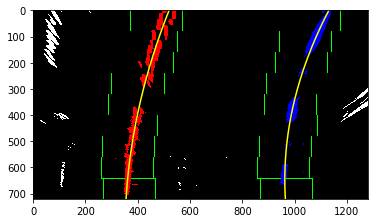

In [5]:
# Write a function to detect lane lines in a warped image
def find_lines(warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[np.int_(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                      (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #plot the pixels of the lane lines in red and blue colors
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lines(warped)

# Plot the result
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [6]:
# Write a function that detects lines taking into account the lines from the previous image
def find_next_lines(warped, left_fitx, right_fitx, ploty, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

## 6th Step : Draw the lane lines in the undistorted image:

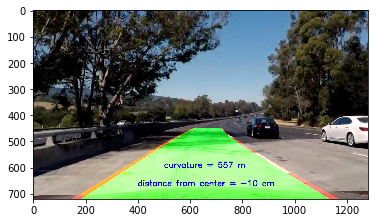

In [7]:
# Write a function that draws the detected lines in the original undistorted image and computes the curvature and distance from centerr
def draw_lines(undistorted_image, warped_image, left_fitx, right_fitx, ploty):
    left_fitx = np.int_(left_fitx)
    right_fitx = np.int_(right_fitx)
    ploty = np.int_(ploty)
    window_img_lines = np.zeros_like(warped_image, dtype="uint8")
    window_img_lane = np.zeros_like(warped_image, dtype="uint8")
    for i in range(np.size(left_fitx)):
        window_img_lines[ploty[i]-10:ploty[i]+10,left_fitx[i]-10:left_fitx[i]+10] = 255
        window_img_lines[ploty[i]-10:ploty[i]+10,right_fitx[i]-10:right_fitx[i]+10] = 255
        window_img_lane[ploty[i],left_fitx[i]+11:right_fitx[i]-11] = 255

    mask = np.dstack((window_img_lines,window_img_lane,np.zeros_like(warped_image, dtype="uint8")))
    mask_rewarped = corners_rewarp(mask,nx, ny, mtx, dist, corners)
    output = cv2.addWeighted(undistorted_image, 1, mask_rewarped, 0.7, 0.0)
    
    y_eval = np.size(output,0)
    x_eval = np.size(output,1)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Computing radius of curvature is in meters
    curvature = np.int_((left_curverad+right_curverad)/2)
    str_curvature = str('curvature = '+str(curvature)+' m')
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output,str_curvature,(500,600), font, 1,(0,0,255),2,cv2.LINE_AA)
    
    #Computing the distance from center in centimeters
    distance_center = np.int_(((x_eval/2)-(left_fitx[y_eval-1]+(right_fitx[y_eval-1]-left_fitx[y_eval-1])/2))*xm_per_pix*100)
    str_distance = str('distance from center = '+str(distance_center)+' cm')
    cv2.putText(output,str_distance,(400,670), font, 1,(0,0,255),2,cv2.LINE_AA)
    return output

# Test the function and show the result
output = draw_lines(undistorted, warped, left_fitx, right_fitx, ploty)
plt.imshow(output)
plt.show()

## 7th Step : Create a pipeline using all the previous functions:

In [8]:
# Write a pipeline for the processing of the image
undistorted, mtx, dist = cal_undistort(image, objpoints, imgpoints)
def process_image(image):
    global j, left_fitx, right_fitx, ploty, left_fit, right_fit, ndistorted, mtx, dist
       
    result, binary = pipeline(undistorted)
    
    warped = corners_unwarp(binary, nx, ny, mtx, dist, corners)
    if j==0:
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_lines(warped)
        j=1
    else:
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = find_next_lines(warped, left_fitx, right_fitx, ploty, left_fit, right_fit)
    
    output = draw_lines(undistorted, warped,left_fitx, right_fitx, ploty)
    
    return output

## 8th Step : Apply the pipeline on a video

In [9]:
# Aplly the pipeline on a video

# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

j = 0
white_output = 'output_project_video_lane_lines_detection.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [19:45<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 19min 48s, sys: 13.1 s, total: 20min 1s
Wall time: 19min 47s
